# Problem Session 4

The problems in this notebook will cover the content covered in our Regression lectures including:
- Regularization
- Principle Component Analysis
- Categorical Variables and Interactions
- Pipelines

In [1]:
## We first load in packages we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

#### 1. Practice creating mock data and fitting models to it

Creating your own fake data and fitting models to that data is a good way to practice.  It is nice because you have access to the "ground truth" when you make your own data.

Another more practical usage of simulation is parametric bootstrapping, which we will cover in a few lectures.

It is also *very common* to need to mock up some data during an interview.

##### a.  

We will start by creating a design matrix $X$ with $20$ rows and $10$ columns whose first $9$ columns are all quite close to each other.  The last column will be distinct, so that X is "close to" being a rank 2 matrix.  

Then we will have $y$ be the sum of all columns plus some noise.

So the true functional relationship is just to sum all the features!

##### Sample Solution

In [2]:
# nobs is short for "number of observations"
nobs = 20

# A numpy array of shape (nobs,) whose entries are drawn uniformly from the interval [0,10]
x = np.random.uniform(low = 0, high = 10, size = (nobs,))

# A numpy array of shape (nobs, 10).  Each column should be x plus normal errors with standard deviation 0.1
# Note that we will overwrite the final column in the next step.
# Hint: use np.tile.  Look up the docs!
X = np.tile(x[:, np.newaxis], (1, 10)) + 0.1*np.random.normal(size = (nobs,10))

# Overwrite the last column of X with new independent draws from [0,10]
X[:,9] = np.random.uniform(low = 0, high = 10, size = (nobs,))

# A numpy array of shape (nobs,) which is equal to the sum of the columns of X plus normal errors of variance 1.
y = X.sum(axis=1) + np.random.normal(size = (nobs,))

In [3]:
# Making a train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test = train_test_split(X,y)

##### b.

We will now fit a standard linear regression, ridge regression, and PCA regression model to the data.  We want to compare mean squared error on the test set.

##### Sample Solution

In [4]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse

In [5]:
# Instantiate the models. Which ones need scaling?
lr = LinearRegression()
ridge_pipe = Pipeline([('scale', StandardScaler()), ('ridge', Ridge())])
pca_pipe = Pipeline([('scale', StandardScaler()), ('pca', PCA(2)), ('reg', LinearRegression())])

# Fit the models to the training data
lr.fit(X_train, y_train)
ridge_pipe.fit(X_train, y_train)
pca_pipe.fit(X_train, y_train)

# Find the model predictions on the training set
lr_train_preds = lr.predict(X_train)
ridge_train_preds = ridge_pipe.predict(X_train)
pca_train_preds = pca_pipe.predict(X_train)

# Find the model predictions on the test set
lr_test_preds = lr.predict(X_test)
ridge_test_preds = ridge_pipe.predict(X_test)
pca_test_preds = pca_pipe.predict(X_test)

# Find the mse on the training set
lr_train_mse = mse(y_train, lr_train_preds)
ridge_train_mse = mse(y_train, ridge_train_preds)
pca_train_mse = mse(y_train, pca_train_preds)

# Find the mse on the test set
lr_test_mse = mse(y_test, lr_test_preds)
ridge_test_mse = mse(y_test, ridge_test_preds)
pca_test_mse = mse(y_test, pca_test_preds)

# Results
print(f"OLS Training MSE: {lr_train_mse}")
print(f"Ridge Training MSE: {ridge_train_mse}")
print(f"PCA Training MSE: {pca_train_mse}")
print(f"OLS Test MSE: {lr_test_mse}")
print(f"Ridge Test MSE: {ridge_test_mse}")
print(f"PCA Test MSE: {pca_test_mse}")

OLS Training MSE: 0.35561386142516044
Ridge Training MSE: 1.3935550357250153
PCA Training MSE: 1.3359151412656756
OLS Test MSE: 3.412775677634694
Ridge Test MSE: 1.202883970707482
PCA Test MSE: 1.031861438725831


In [6]:
# Use this cell to click "run all above" a number of times.  Discuss with your group.
# Will OLS always outperform the other two models on the training set?  Will it ever outperform on the testing set?

#### c.

Lasso deals with multicollinearity poorly in the sense that it will often "randomly" choose which columns to keep and which to discard.  So we should expect that Lasso will keep the last feature (which is not correlated with the first $9$), and randomly choose from the first $9$.  Let's see if that pans out.

### Sample Solution

In [7]:
from sklearn.linear_model import Lasso

In [8]:
alphas = np.exp(np.linspace(-6,-1,8))
coefs = np.zeros((len(alphas), 10))
for i,alpha in enumerate(alphas):
    # Make a pipeline where you first scale and then lasso.
    # Use max_iter=100000 in your Lasso to avoid some convergence issues.
    lasso_pipe = Pipeline([('scale', StandardScaler()),('lasso', Lasso(alpha = alpha, max_iter=100000))])

    # Fit it to the training data
    lasso_pipe.fit(X_train, y_train)

    # Store the coefficients in the ith row of coefs 
    coefs[i,:] = lasso_pipe['lasso'].coef_

pd.DataFrame(coefs)


,0,1,2,3,4,5,6,7,8,9
0,4.783508,1.106211,-4.945902,-9.156671,20.526787,10.392671,9.638276,-1.123100,-0.0,3.002168
1,4.042613,0.000000,-0.341455,-4.484763,16.438022,6.895129,8.669130,-0.000000,-0.0,3.032846
2,3.823947,0.000000,-0.000000,-0.000000,13.953535,6.611434,6.824745,0.000000,-0.0,3.053328
3,4.136149,0.000000,0.000000,0.000000,13.853153,6.303803,6.910861,0.000000,0.0,3.037055
4,4.776844,0.000000,0.000000,0.000000,13.651128,5.661892,7.094312,0.000000,0.0,3.003652
5,6.084354,0.000000,0.000000,0.000000,13.235382,4.359159,7.464847,0.000000,0.0,2.935510
6,8.751820,0.000000,0.000000,0.000000,12.365942,1.751016,8.192324,0.000000,0.0,2.796849
7,12.691512,0.000000,0.000000,0.000000,10.152276,0.000000,7.722426,0.323568,0.0,2.557994


In [9]:
# Use this cell to click "run all above" a number of times.  Discuss with your group.
# Does Lasso always select feature 9?  Is the choice of other features to keep consistent?

#### Bonus 

Only do this if you got done with everything above in the first 20 minutes or so.  Otherwise come back to it at the end.

Write a function which repeats everything from part (a) and (b) above 1000 times and records how often Ridge beats OLS and PCA regression beats OLS on the test set.

### Sample Solution

In [10]:
def generate_data(nobs=20, noise_y=1, noise_X=0.1):
    x = np.random.uniform(low=0, high=10, size=(nobs,))
    X = np.tile(x[:, np.newaxis], (1, 10)) + noise_X * np.random.normal(size=(nobs, 10))
    y = X.sum(axis=1) + np.random.normal(scale=noise_y, size=(nobs,))
    return X, y

def compare_models(n_iterations=1000, nobs=20, noise_y=1, noise_X=0.1):
    ridge_wins = 0
    pca_wins = 0

    for _ in range(n_iterations):
        # Generate synthetic data
        X, y = generate_data(nobs, noise_y, noise_X)

        # Split data into training and testing sets
        split_index = int(0.8 * nobs)  # 80% training, 20% testing
        X_train, X_test, y_train, y_test = train_test_split(X, y)

        # Fit models
        lr = LinearRegression().fit(X_train, y_train)
        ridge_pipe = Pipeline([('scale', StandardScaler()), ('ridge', Ridge())]).fit(X_train, y_train)
        pca_pipe = Pipeline([('scale', StandardScaler()), ('pca', PCA(n_components=1)), ('reg', LinearRegression())]).fit(X_train, y_train)

        # Make predictions
        lr_preds = lr.predict(X_test)
        ridge_preds = ridge_pipe.predict(X_test)
        pca_preds = pca_pipe.predict(X_test)

        # Calculate MSE
        lr_mse = mse(y_test, lr_preds)
        ridge_mse = mse(y_test, ridge_preds)
        pca_mse = mse(y_test, pca_preds)

        # Compare models
        if ridge_mse < lr_mse:
            ridge_wins += 1

        if pca_mse < lr_mse:
            pca_wins += 1

    return ridge_wins/n_iterations, pca_wins/n_iterations

# Example usage
ridge_wins, pca_wins = compare_models()
print(f"Ridge wins: {ridge_wins}, PCA wins: {pca_wins}")

Ridge wins: 0.886, PCA wins: 0.896


Note:  If you only got through part 1 in this problem session that is fine.  You have already rehearsed all of the skills from lecture, and hopefully had a few insights as well.

The next part is therefore "optional".  I am including it for the groups that are really speedy.  It also feels bad to have a problem session without real data!  You can certainly treat part 2 as "homework" if you run have out of time.

The new dataset also doesn't really seem to benefit much from regularization, so the new techniques from this week are not very rewarding.  Think of it as just more regression practice.  There is also one new idea of "controlling for a variable" which is introduced in this section.

#### 2. The diamonds dataset

We introduce a new "classic" dataset.  Our task is to predict the price of diamonds.

* price: Price in US dollars.
* carat: Weight of the diamond.
* cut: Cut quality (ordered worst to best).
* color: Color of the diamond (ordered best to worst).
* clarity: Clarity of the diamond (ordered worst to best).
* x: Length in mm.
* y: Width in mm.
* z: Depth in mm.
* depth: Total depth percentage: 100 * z / mean(x, y)
* table: Width of the top of the diamond relative to the widest point.

Homepage: https://ggplot2.tidyverse.org/reference/diamonds.html

In [11]:
df = pd.read_csv('../../data/diamonds.csv')

In [12]:
df

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


For sake of time we will restrict ourselves to just one categorical feature (`cut`) and one continuous feature (`carat`) in our modeling.  This is only being done for pedagogical purposes!  In a real situation you would want to carefully explore all of the data you have available.

In [13]:
df = df[['cut', 'carat', 'price']]

#### a.

### Sample Solution

In [14]:
# Make a train/test split with 20% of data held aside as the test set.
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=216)

X_train = df_train[['cut', 'carat']]
X_test = df_test[['cut', 'carat']]
y_train = df_train.price
y_test = df_test.price

##### b. 

What are the percentage of samples belonging to each level of the `cut` feature?

### Sample Solution

In [15]:
100*X_train.cut.value_counts()/X_train.shape[0]

cut
Ideal        39.859103
Premium      25.583982
Very Good    22.548202
Good          9.023915
Fair          2.984798
Name: count, dtype: float64

##### c. 

Look at the distribution of price at each level of the `cut` feature.  Do you notice anything strange or unexpected?

### Sample Solution

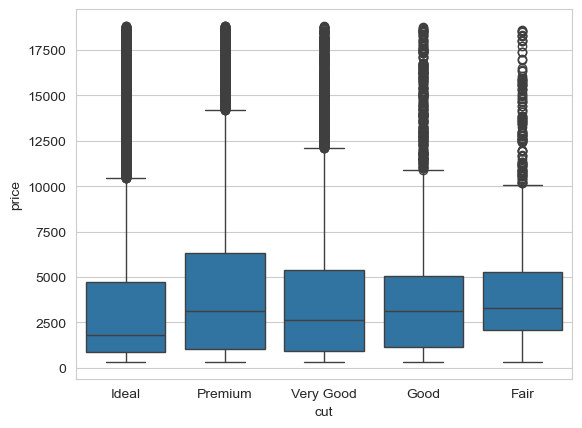

In [16]:
sns.boxplot(data=df_train, x = 'cut', y='price')
plt.show()

##### d. 

One thing which might be a bit confusing is that the cut quality does not seem to be a very good indicator of price.  Why might that be?

Sometimes this happens when two predictors which each have a positive **causal** impact on the outcome are negatively correlated with each other.  In other words, it might be that **all else being equal** a higher quality cut will increase the price, and a larger carat will increase the price, but higher quality cuts are negatively correlated with the size in carats.

Use the `groupby` and `describe` methods to look at some summary statistics of carat size sorted by cut quality.

### Sample Solution

In [17]:
df_train.groupby('cut').carat.describe().loc[['Ideal', 'Premium','Very Good','Good','Fair']]

,count,mean,std,min,25%,50%,75%,max
cut,,,,,,,,
Ideal,17200.0,0.703963,0.433304,0.20,0.35,0.54,1.01,3.50
Premium,11040.0,0.892583,0.516738,0.20,0.41,0.83,1.20,4.01
Very Good,9730.0,0.806934,0.457980,0.20,0.41,0.72,1.02,4.00
Good,3894.0,0.852424,0.451219,0.23,0.50,0.90,1.01,3.01
Fair,1288.0,1.051607,0.521006,0.22,0.70,1.00,1.20,5.01


We can see that the "Fair" quality also has the largest mean carat size, while "Ideal" quality has the smallest. I am not a domain expert, but this could be due to jewelers needing to cut away more of the original stone to produce better cuts?  This would be something to consult with a jeweler on.

##### e.

Graph price against carat with color coded by cut quality.

### Sample Solution

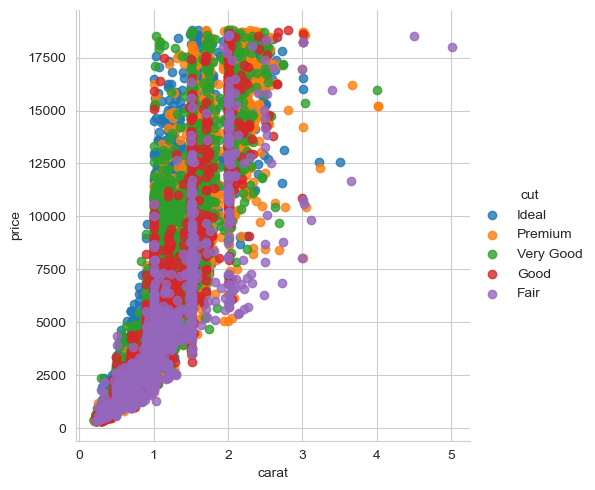

In [18]:
sns.lmplot(data = df_train, x = 'carat', y = 'price', hue = 'cut', fit_reg=False)
plt.show()

##### f.

The relationship you obtained above does not look linear.  Graph the log of the price against the log of the carat size.  This should look substantially more linear!

### Sample Solution

In [19]:
df_train['log_price'] = np.log(df_train['price'])
df_train['log_carat'] = np.log(df_train.carat)

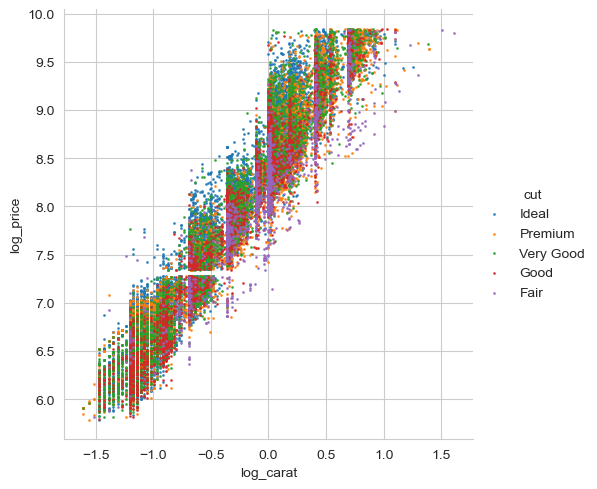

In [20]:
sns.lmplot(data = df_train, x= 'log_carat', y = 'log_price', hue = 'cut', fit_reg = False, scatter_kws={'s':1})
plt.show()

##### g.

We do not have the ability to **experimentally** adjust `cut` and `carat` independently to see the impact on price, but we can still use **statistical control**.

We will run a linear regression of `log_price` against `cut` and `log_carat`.  Do better cuts contribute to higher prices when controlling for carat?

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.linear_model import LinearRegression

In [22]:
# Discuss what you think preprocessor does with your team.  Can you test that it does what you think it should?
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(), ['cut']),
        ('identity', FunctionTransformer(func = None), ['log_carat'])
        ])

# Write a pipeline which first uses preprocessor and then uses LinearRegression(fit_intercept = False). 
# Why do I not want to fit the intercept term?
model = Pipeline([('preprocess', preprocessor),('linear', LinearRegression(fit_intercept = False))])

# Fit it on the training set using the 'cut' and 'log_carat'features (in that order).
model.fit(df_train[['cut','log_carat']], df_train.log_price)

# It is a bit difficult to access the feature names of one part of a pipeline, so I have done it for you.
feature_names = model['preprocess'].transformers_[0][1].get_feature_names_out()

cut_adjustments = {feature_name: float(model['linear'].coef_[i]) for i,feature_name in enumerate(feature_names)}

cut_adjustments_sorted = dict(sorted(cut_adjustments.items(), key=lambda item: item[1]))

cut_adjustments_sorted

{'cut_Fair': 8.199858555480072,
 'cut_Good': 8.36514308340494,
 'cut_Premium': 8.437941267704481,
 'cut_Very Good': 8.440568480455783,
 'cut_Ideal': 8.519414885022087}

#### h. Evaluating residuals

Make a plot of residuals against predicted values.  Discuss the implications for your model.

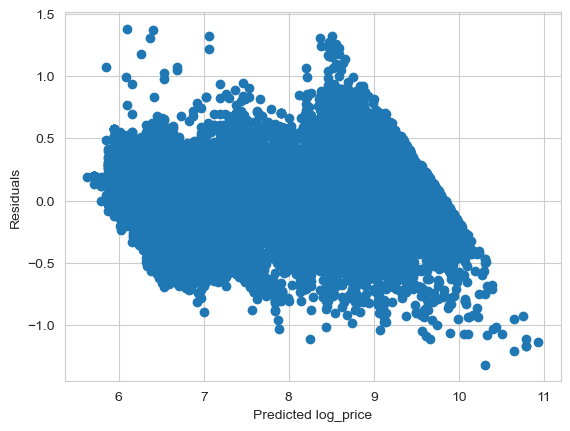

In [23]:
preds = model.predict(df_train[['cut','log_carat']])
residuals = df_train['log_price'] - preds
plt.scatter(preds, residuals)

plt.xlabel('Predicted log_price')
plt.ylabel('Residuals')

plt.show()

The lines in the residual plot are due to the apparent thresholds on price in the training data.  Prices seem to have a soft cap at around $18k and a soft minimum of around $350.

#### i. Quantifying model performance

Let's use [mean absolute percentage error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html) and [mean absolute error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html) as our performance metrics.  

Remember to use these in the units of the original target, not the transformed target!

How does our model perform on the training set?

### Sample Solution

In [24]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

In [25]:
print(f" The mean absolute percentage error is {100*mean_absolute_percentage_error(y_true = df_train.price, y_pred= np.exp(preds)): .1f}%")
print(f" The mean absolute error is ${mean_absolute_error(y_true = df_train.price, y_pred= np.exp(preds)): .1f}")

 The mean absolute percentage error is  20.2%
 The mean absolute error is $ 822.2
